In [ ]:
import tifffile
import glob
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from scipy.spatial.distance import braycurtis
import math
import matplotlib.pyplot as plt
from torch import nn
import torch

In [ ]:
list_path_labels = glob.glob('../data/raw/train/labels/**/*.tif', recursive=True)
list_resume_labels = []
for path_labels in tqdm(list_path_labels, desc='Resume images'):
    labels = tifffile.imread(path_labels)
    labels = labels - 1
    labels = np.where(labels < 13, labels, 12)
    unique, counts = np.unique(labels, return_counts=True)
    labels_distribution = np.zeros((13,))
    resume_labels = {label : 0 for label in range(13)}
    for label, count in zip(unique, counts):
        resume_labels[label] = count
    resume_labels['path_labels'] = path_labels
    list_resume_labels.append(resume_labels)
    
df = pd.DataFrame(list_resume_labels)
df.to_csv('../data/raw/labels-resume-12.csv', index=False)

In [ ]:
np.random.seed(42)
arr_choices = np.random.uniform(0, 1, len(list_path_labels))

In [39]:
train_size = 0.9
distribution_target = torch.tensor(df[list(range(13))].sum(axis=0))

list_path_train = []
distribution_train_futur = torch.zeros((13,))
distribution_train = torch.zeros((13,))
distribution_train_target: torch.Tensor = distribution_target * train_size

list_path_val = []
distribution_val_futur = torch.zeros((13,))
distribution_val = torch.zeros((13,))
distribution_val_target: torch.Tensor = distribution_target * (1 - train_size)


list_path_train_random = []
list_path_val_random = []
distribution_train_random = torch.zeros((13,))
distribution_val_random = torch.zeros((13,))

size_train = train_size - 0.5
weight_train_min = 1

list_coef_loss = []
loss_train = nn.functional.mse_loss(distribution_train, distribution_train_target, reduction='sum')
loss_val = nn.functional.mse_loss(distribution_val, distribution_val_target, reduction='sum')

pbar = tqdm(zip(df.index, arr_choices), total=len(df), desc='Split Train/Val')
for idx, choice in pbar:
    distribution_labels = torch.Tensor(df.loc[idx, list(range(13))])
    
    distribution_train_futur = distribution_train + distribution_labels
    loss_train_futur = nn.functional.mse_loss(distribution_train_futur, distribution_train_target, reduction='sum')
    # loss_train_futur = braycurtis(distribution_train_futur, distribution_train_target)
    
    distribution_val_futur = distribution_val + distribution_labels
    loss_val_futur = nn.functional.mse_loss(distribution_val_futur, distribution_val_target, reduction='sum')
    # loss_val_futur = braycurtis(distribution_val_futur, distribution_val_target)
    
    loss_diff_train = loss_train - loss_train_futur
    loss_diff_val = loss_val - loss_val_futur
    
    tensor = torch.Tensor([loss_diff_train, loss_diff_val])
    # tensor = torch.Tensor([loss_train_futur, loss_val_futur])
    # Normalize for sensibility of softmax
    tensor_norm = nn.functional.normalize(tensor, dim=0)
    # Softmax to have a vector of probability
    proba_train_val = nn.functional.softmax(tensor_norm, dim=0)
    # print(tensor, tensor_norm, proba_train_val)
    pbar.set_postfix_str(f'Proba: train={proba_train_val[0]:1f} - val={proba_train_val[1]:1f}')
    
    if choice < proba_train_val[0]:
        distribution_train = distribution_train_futur
        loss_train = loss_train_futur
        list_path_train.append(df.loc[idx, 'path_labels'])
    else:
        distribution_val = distribution_val_futur
        loss_val = loss_val_futur
        list_path_val.append(df.loc[idx, 'path_labels'])
    
    if choice < 0.9:
        distribution_train_random = distribution_train_random + distribution_labels
        list_path_train_random.append(df.loc[idx, 'path_labels'])
    else:
        distribution_val_random = distribution_val_random + distribution_labels
        list_path_val_random.append(df.loc[idx, 'path_labels'])
    

Split Train/Val:   0%|          | 0/61712 [00:00<?, ?it/s]

In [44]:
from sklearn.model_selection import train_test_split

df_train, df_val = train_test_split(df, train_size=0.9)

distribution_train = df_train[list(range(13))].sum()
distribution_val = df_val[list(range(13))].sum()

In [45]:
distribution_train_pct = distribution_train / distribution_train.sum() * 100
distribution_val_pct = distribution_val / distribution_val.sum() * 100
distribution_target_pct = distribution_target / distribution_target.sum() * 100

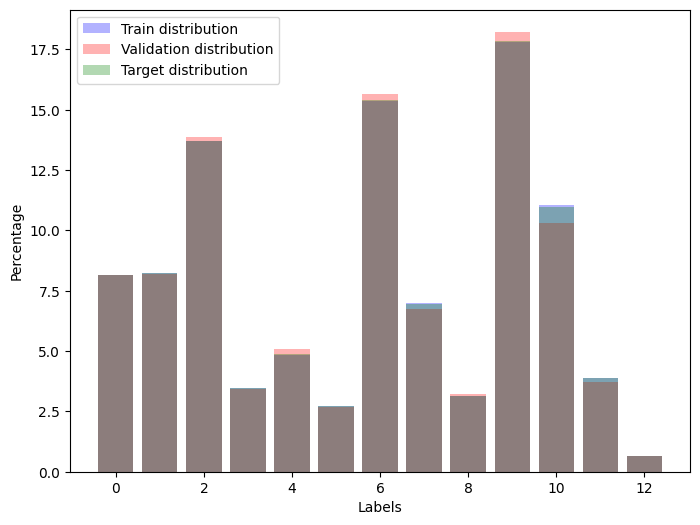

In [46]:
plt.figure(figsize=(8, 6))
plt.bar(list(range(13)), distribution_train_pct, color='blue', alpha=0.3, label='Train distribution')
plt.bar(list(range(13)), distribution_val_pct, color='red', alpha=0.3, label='Validation distribution')
plt.bar(list(range(13)), distribution_target_pct, color='green', alpha=0.3, label='Target distribution')
plt.xlabel('Labels')
plt.ylabel('Percentage')
plt.legend()
plt.show()

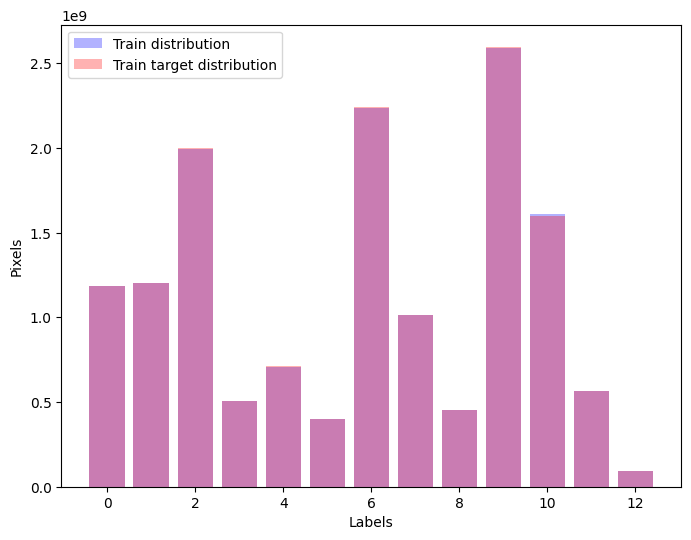

In [47]:
plt.figure(figsize=(8, 6))
# plt.bar(list(range(13)), distribution_train_random, color='green', alpha=0.3, label='Train distribution random')
plt.bar(list(range(13)), distribution_train, color='blue', alpha=0.3, label='Train distribution')
plt.bar(list(range(13)), distribution_train_target, color='red', alpha=0.3, label='Train target distribution')
plt.xlabel('Labels')
plt.ylabel('Pixels')
plt.legend()
plt.show()

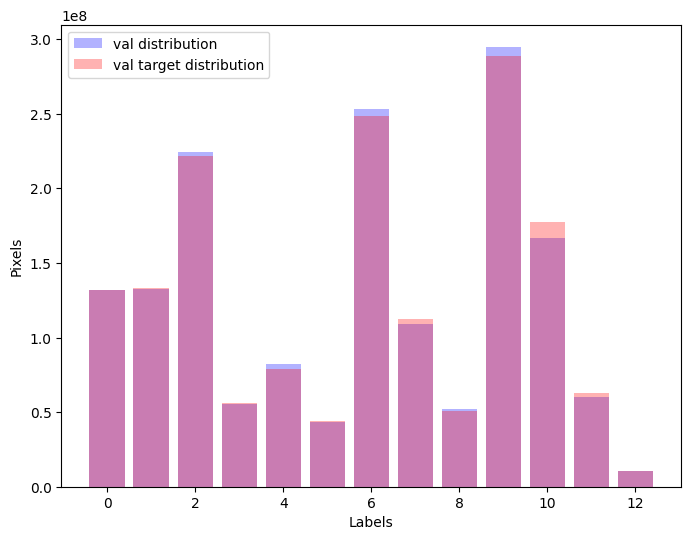

In [49]:
plt.figure(figsize=(8, 6))
# plt.bar(list(range(13)), distribution_val_random, color='green', alpha=0.3, label='val distribution random')
plt.bar(list(range(13)), distribution_val, color='blue', alpha=0.3, label='val distribution')
plt.bar(list(range(13)), distribution_val_target, color='red', alpha=0.3, label='val target distribution')
plt.xlabel('Labels')
plt.ylabel('Pixels')
plt.legend()
plt.show()

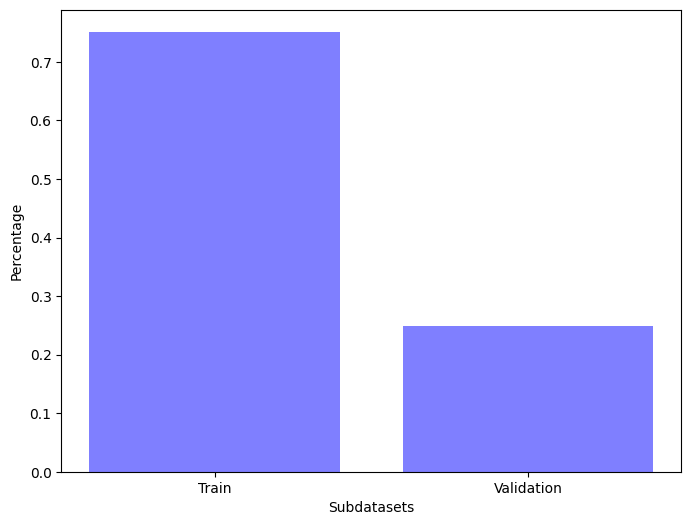

In [50]:
plt.figure(figsize=(8, 6))
plt.bar(['Train', 'Validation'], [len(df_tain) / len(df), len(df_val) / len(df)], color='blue', alpha=0.5)
plt.xlabel('Subdatasets')
plt.ylabel('Percentage')
plt.show()

In [ ]:
distribution_train_random_pct = distribution_train_random / distribution_train_random.sum() * 100
distribution_val_random_pct = distribution_val_random / distribution_val_random.sum() * 100

plt.figure(figsize=(8, 6))
plt.bar(list(range(13)), distribution_train_random_pct, color='blue', alpha=0.3, label='Train distribution')
plt.bar(list(range(13)), distribution_val_random_pct, color='red', alpha=0.3, label='Validation distribution')
plt.bar(list(range(13)), distribution_target_pct, color='green', alpha=0.3, label='Target distribution')
plt.xlabel('Labels')
plt.ylabel('Percentage')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(8, 6))
plt.bar(['Train', 'Validation'], [len(list_path_train_random) / len(df), len(list_path_val_random) / len(df)], color='blue', alpha=0.5)
plt.xlabel('Subdatasets')
plt.ylabel('Percentage')
plt.show()

In [ ]:
plt.figure(figsize=(8, 6))
plt.bar(list(range(13)), distribution_train_random, color='blue', alpha=0.3, label='train distribution random')
plt.bar(list(range(13)), distribution_train_target, color='red', alpha=0.3, label='train target distribution')
plt.xlabel('Labels')
plt.ylabel('Pixels')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(8, 6))

plt.bar(list(range(13)), distribution_val_target, color='red', alpha=0.3, label='val target distribution')
plt.xlabel('Labels')
plt.ylabel('Pixels')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(8, 6))
plt.bar(['Train', 'Validation'], [len(list_path_train_random) / len(df), len(list_path_val_random) / len(df)], color='green', alpha=0.3)
plt.bar(['Train', 'Validation'], [len(list_path_train) / len(df), len(list_path_val) / len(df)], color='blue', alpha=0.3)
plt.xlabel('Subdatasets')
plt.ylabel('Percentage')
plt.show()